# Importing Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.colors import Normalize, LinearSegmentedColormap
from IPython.display import display, Image, clear_output
from bs4 import BeautifulSoup
import geopandas as gpd
import numpy as np

# Loading of Datasets

This project uses two datasets:

1. **Singapore's Planning Boundary**
   - **Description:** This dataset provides information on Singapore's planning boundaries.
   - **Source:** [Singapore's Planning Boundary Dataset](https://data.gov.sg/datasets/d_4765db0e87b9c86336792efe8a1f7a66/view)
2. **Singapore's Covid-19 Cases**
   - **Description:** This dataset contains data for visualizing the spread of COVID-19 in Singapore.
   - **Source:** [Visualising SG Covid-19 Spread's Dataset](https://docs.google.com/spreadsheets/d/19EPRvGyAMnYZn9LwfFa4UqYrt-MQ94-qEUg76vbl2Gs/edit?usp=sharing)


In [2]:
# Loading Singapore's Map in GeoJson
geojson_file = "MasterPlan2019PlanningAreaBoundaryNoSea.geojson"
gdf = gpd.read_file(geojson_file)
gdf.crs = "EPSG:4326"

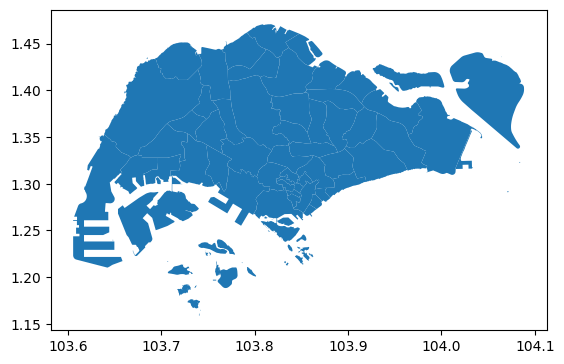

In [3]:
# Check if GeoJson file is loaded properly
gdf.plot()
plt.show()

# Data Cleaning (Done with R)

Address and correct formatting inconsistencies in the `Date` and `Time` columns.

#### **Formatting Errors for "Time" Column**

1. **Missing Spacing**
   - **Example:** `0000h -0000h`
   - **Correction:** Ensure there is a space before and after the dash.

2. **Incorrect Dash Character**
   - **Example:** `0000h – 0000h` (Uses an en-dash "–" instead of a hyphen "-")
   - **Correction:** Replace the en-dash "–" with a hyphen "-".

#### **Formatting Errors for "Date" Column**

1. **Additional Time Component**
   - **Example:** `00/00/0000 0:00:00`
   - **Correction:** Remove the time component if it is not required, or ensure all dates are formatted consistently without time
   
#### **Source Files:**

- `data_prep1.R`

# Data Preparation (Done with R)

#### **Data Preparation:**

- Extracted relevant values from the GeoJSON `Description` field and created a new dataframe.
- Merged location data with geographic boundaries data based on area names.
- Converted `Time` to a standardized start time format and combined it with `Date` to create a `Datetime` column.
- Dropped unnecessary columns and exported the cleaned dataframe to `covid_cases_cleaned.csv`.

#### **Further Processing:**

- Re-imported the cleaned data and converted `Datetime` to POSIXct format.
- Extracted the date part and converted columns to character to avoid factor issues.
- Aggregated data by date and name, counting occurrences.
- Created a dataframe with all date-name combinations and merged it with aggregated data to ensure complete coverage.
- Replaced NA values with zeros and calculated cumulative case counts for each location.
- Exported the cumulative cases dataframe to `cumulative_cases.csv`.

#### **Source Files:**

- `data_prep1.R` for Data Preparation
- `data_prep2.R` for Further Processing

# Visualisation Technique 1: Spatio-Temporal Animation of Covid-19 Cases

### Data Loading

In [4]:
# Loading of Cleaned Covid-19 Cases Dataset
filepath = "covid_cases_cleaned.csv"
covid_clean = pd.read_csv(filepath)
covid_clean.head()

,Area,Longitude,Latitude,Name,Datetime
0,ANG MO KIO,103.834690,1.352578,kml_52,2020-06-28 14:00:00
1,ANG MO KIO,103.847869,1.370731,kml_52,2021-05-16 14:15:00
2,ANG MO KIO,103.847677,1.364625,kml_52,2021-06-20 18:20:00
3,ANG MO KIO,103.856414,1.377509,kml_52,2020-08-19 12:00:00
4,ANG MO KIO,103.836519,1.360520,kml_52,2021-05-17 10:00:00


In [5]:
# Convert the 'Datetime' column to a Datetime object
covid_clean['Datetime'] = pd.to_datetime(covid_clean['Datetime'])

# Create a new column 'Date' that contains just the date part
covid_clean['Date'] = covid_clean['Datetime'].dt.date

# Sort by the 'Datetime' column
# covid_clean = covid_clean.sort_values(by='Datetime')

covid_clean.head()

,Area,Longitude,Latitude,Name,Datetime,Date
0,ANG MO KIO,103.834690,1.352578,kml_52,2020-06-28 14:00:00,2020-06-28
1,ANG MO KIO,103.847869,1.370731,kml_52,2021-05-16 14:15:00,2021-05-16
2,ANG MO KIO,103.847677,1.364625,kml_52,2021-06-20 18:20:00,2021-06-20
3,ANG MO KIO,103.856414,1.377509,kml_52,2020-08-19 12:00:00,2020-08-19
4,ANG MO KIO,103.836519,1.360520,kml_52,2021-05-17 10:00:00,2021-05-17


### Overall Animation of All COVID-19 Cases

This cell creates an animation showing the distribution of COVID-19 cases across the entire dataset from start to end. The animation will be saved as a GIF file.


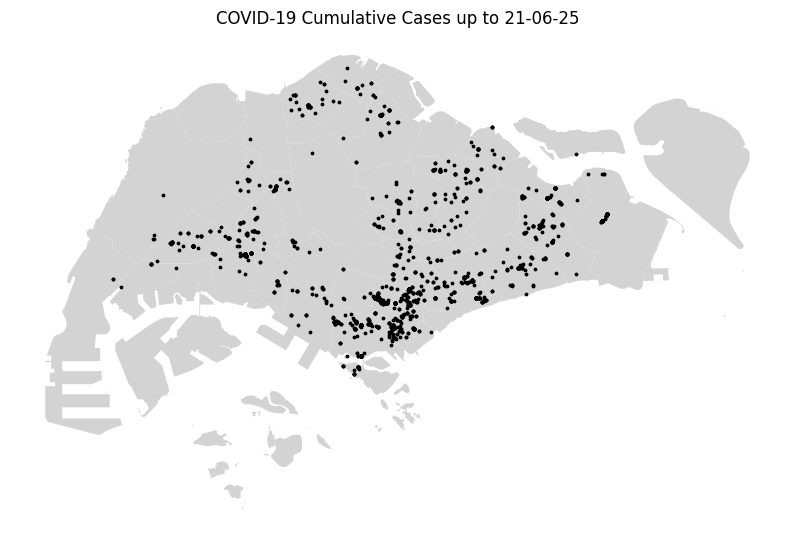

In [6]:
# Animation of cumulative Covid-19 Cases over time
run_cell = True

if run_cell:
    # Extract unique dates and sort them
    unique_dates = sorted(covid_clean['Datetime'].unique())

    # Create a figure and axis
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    # Define the update function for FuncAnimation
    def update(frame):
        ax.clear()

        ####### Data Preparation for each frame #######

        # Get the current date
        date = unique_dates[frame]

        # Plot base map
        gdf.plot(ax=ax, color='lightgray')

        ####### Scatter Plot #######

        # Filter cases up to and including the current date
        cases = covid_clean[covid_clean['Datetime'] <= date]

        ax.scatter(cases['Longitude'], cases['Latitude'], color='black', s=3)

        ####### Axes Settings #######

        # Remove axes
        ax.set_axis_off()

        # Format the date as 'yy-mm-dd'
        formatted_date = pd.Timestamp(date).strftime('%y-%m-%d')

        # Set the title with total cases
        ax.set_title(f'COVID-19 Cumulative Cases up to {formatted_date}')

    # Create the animation
    ani = FuncAnimation(fig, update, frames=len(unique_dates), repeat=False)

    # Save the animation as a GIF (optional)
    ani.save('animation1.gif', writer=PillowWriter(fps=15))

    # Display the animation
    plt.show()


In [7]:
# Display GIF inline in Jupyter Notebook (Uncomment the code and rerun the cell to display the animation)
# gif_path = 'animation1.gif'
# display(Image(filename=gif_path))

### Rolling 5-Day Window Animation

This cell creates an animation showing the distribution of individual COVID-19 cases based on a rolling 5-day window. The animation will be saved as a GIF file.


### Experimentation

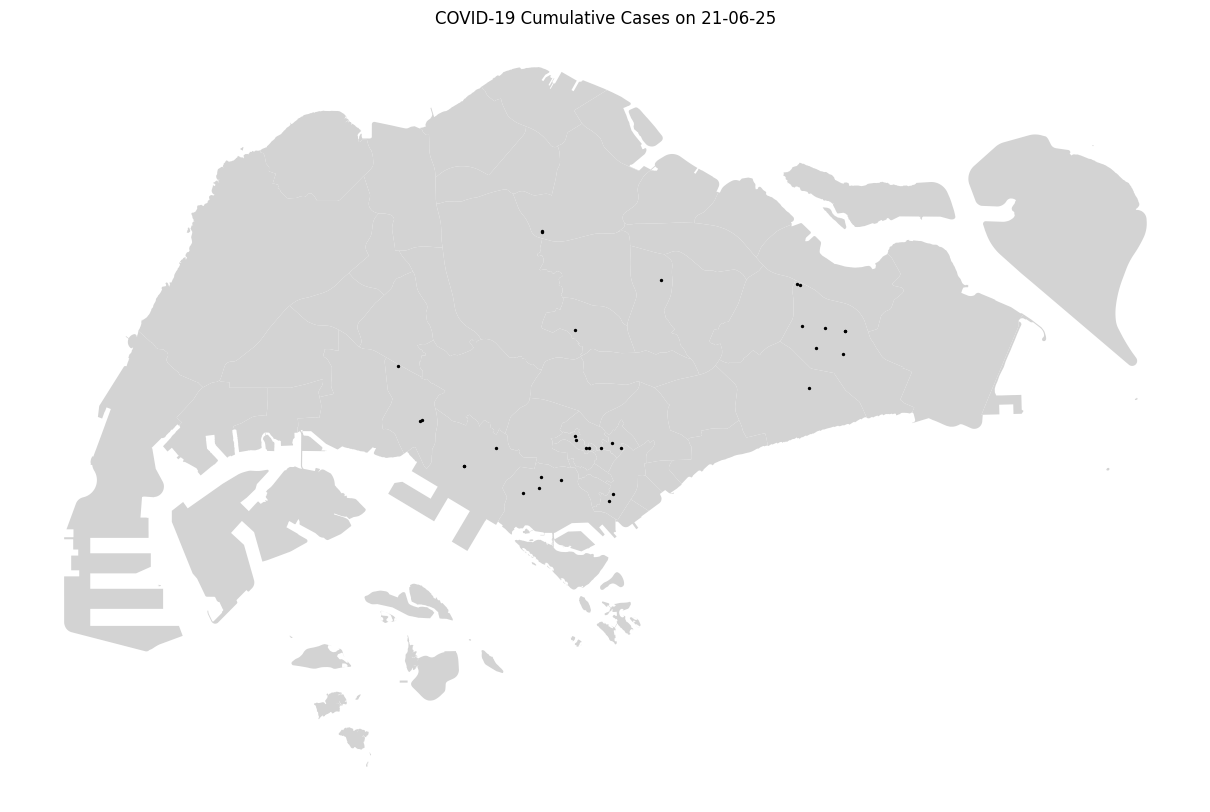

In [8]:
# Generate and display scatter plots of COVID-19 cases over time with a 5-day rolling window. 
# (Set run_cell to True and rerun the code)

# Assuming cumulative_cases and gdf are defined
unique_dates = sorted(covid_clean['Datetime'].unique())

# Create a plot

# Loop over each unique date
for i, date in enumerate(unique_dates):
    clear_output(wait=True)

    ####### Initialise plot #######

    fig, ax = plt.subplots(1, 1, figsize=(20, 10))

    # Clear and redraw the plot
    ax.clear()

    # Plot base map
    gdf.plot(ax=ax, color='lightgray')

    ####### Scatter Plot #######

    # Filter cases within the last 5 days
    start_date = date - pd.Timedelta(days=5)

    cases = covid_clean[(covid_clean['Datetime'] >= start_date) & (covid_clean['Datetime'] <= date)]

    ax.scatter(cases['Longitude'], cases['Latitude'], color='black', s=2)

    ####### Axes Settings #######

    # Remove axes
    ax.set_axis_off() 

    # Format the date as 'yy-mm-dd'
    formatted_date = pd.Timestamp(date).strftime('%y-%m-%d')

    # Set the title with total cases
    ax.set_title(f'COVID-19 Cumulative Cases on {formatted_date}')

    # Display the plot
    plt.show()

    # Close the figure to avoid memory issues
    plt.close(fig)

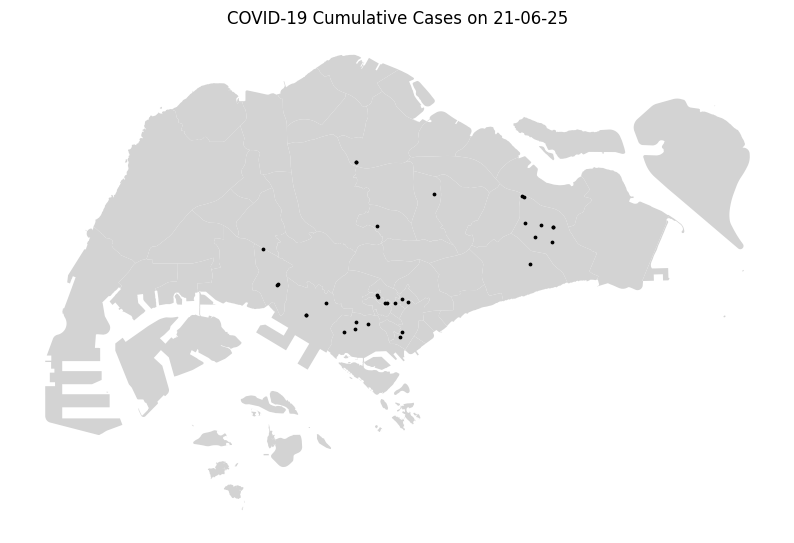

In [9]:
# Animation of individual Covid-19 Cases with Rolling 5-Day Window 
# (Set run_cell to True and rerun the code)
run_cell = True

if run_cell:
    # Extract unique dates
    unique_dates = sorted(covid_clean['Datetime'].unique())

    # Create a figure and axis
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    # Define the update function for FuncAnimation
    def update(frame):
        ax.clear()

        ####### Data Preparation for each frame #######

        # Get the current date
        date = unique_dates[frame]

        # Plot base map
        gdf.plot(ax=ax, color='lightgray')

        ####### Scatter Plot #######

        # Filter cases within the last 5 days
        start_date = date - pd.Timedelta(days=5)

        cases = covid_clean[(covid_clean['Datetime'] >= start_date) & (covid_clean['Datetime'] <= date)]

        ax.scatter(cases['Longitude'], cases['Latitude'], color='black', s=3)

        ####### Axes Settings #######

        # Remove axes
        ax.set_axis_off() 

        # Format the date as 'yy-mm-dd'
        formatted_date = pd.Timestamp(date).strftime('%y-%m-%d')

        # Set the title with total cases
        ax.set_title(f'COVID-19 Cumulative Cases on {formatted_date}')

    # Create the animation
    ani = FuncAnimation(fig, update, frames=len(unique_dates), repeat=False)

    # Save the animation as a GIF (optional)
    ani.save('animation2.gif', writer=PillowWriter(fps=15))

    # Display the animation
    plt.show()

In [10]:
# Display GIF inline in Jupyter Notebook (Uncomment the code and rerun the cell to display the animation)
# gif_path = 'animation2.gif'
# display(Image(filename=gif_path))

This cell creates an animation showing the distribution of all COVID-19 cases in a day based on a rolling 5-day window. The animation will be saved as a GIF file.

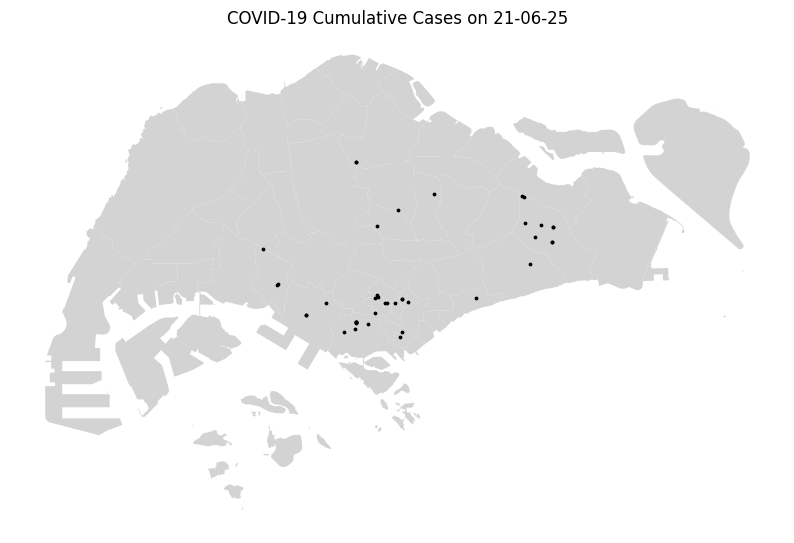

In [11]:
# Animation of all Covid-19 Cases in a day with Rolling 5-Day Window 
# (Set run_cell to True and rerun the code)
run_cell = True

if run_cell:
    # Extract unique dates
    unique_dates = sorted(covid_clean['Date'].unique())

    # Create a figure and axis
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    # Define the update function for FuncAnimation
    def update(frame):
        ax.clear()

        ####### Data Preparation for each frame #######

        # Get the current date
        date = unique_dates[frame]

        # Plot base map
        gdf.plot(ax=ax, color='lightgray')

        ####### Scatter Plot #######

        # Filter cases within the last 5 days
        start_date = date - pd.Timedelta(days=5)

        cases = covid_clean[(covid_clean['Date'] >= start_date) & (covid_clean['Date'] <= date)]

        ax.scatter(cases['Longitude'], cases['Latitude'], color='black', s=3)

        ####### Axes Settings #######

        # Remove axes
        ax.set_axis_off() 

        # Format the date as 'yy-mm-dd'
        formatted_date = pd.Timestamp(date).strftime('%y-%m-%d')

        # Set the title with total cases
        ax.set_title(f'COVID-19 Cumulative Cases on {formatted_date}')

    # Create the animation
    ani = FuncAnimation(fig, update, frames=len(unique_dates), repeat=False)

    # Save the animation as a GIF (optional)
    ani.save('animation3.gif', writer=PillowWriter(fps=15))

    # Display the animation
    plt.show()

In [12]:
# Display GIF inline in Jupyter Notebook (Uncomment the code and rerun the cell to display the animation)
# gif_path = 'animation3.gif'
# display(Image(filename=gif_path))

# Visualisation Technique 2: Chloropleth Maps of Covid-19 Cases in Singapore

### Data Loading

In [13]:
# Loading cumulative dataset
filepath = "cumulative_cases.csv"
cumulative_cases = pd.read_csv(filepath)
cumulative_cases.head()

,Date,Name,Count,Cumulative
0,2020-05-16,kml_1,0,0
1,2020-05-16,kml_10,0,0
2,2020-05-16,kml_11,0,0
3,2020-05-16,kml_12,0,0
4,2020-05-16,kml_13,0,0


### Experimentation

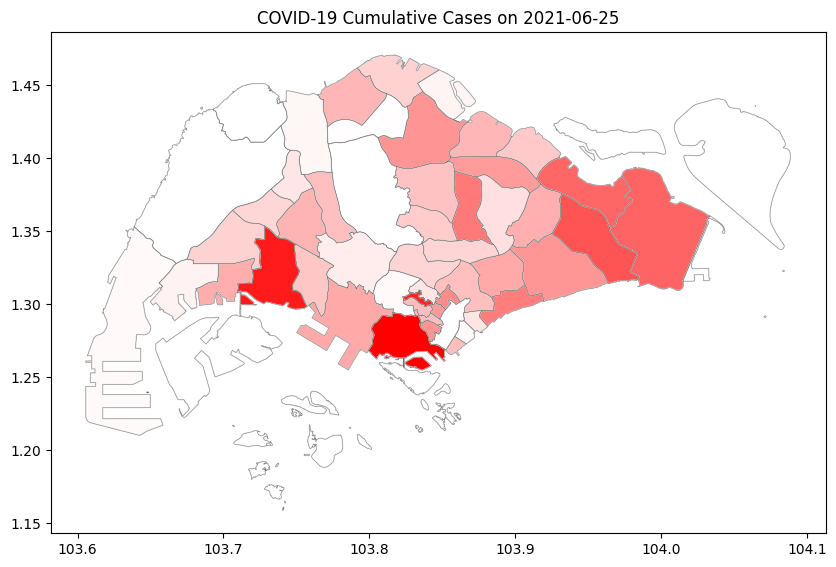

In [14]:
# Generate and display choropleth maps of cumulative COVID-19 cases for each date with a custom color map.

# Assuming cumulative_cases and gdf are defined
unique_dates = sorted(cumulative_cases['Date'].unique())

# Define a custom color map where 0 is white
colors = ['white', 'red']  # Adjust the colors as needed
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

# Define the normalization based on the entire dataset
norm = Normalize(vmin=cumulative_cases['Cumulative'].min(), vmax=cumulative_cases['Cumulative'].max())

# Loop over each unique date
for i, date in enumerate(unique_dates):
    clear_output(wait=True)
    
    # Filter data for the current date
    data_for_date = cumulative_cases[cumulative_cases['Date'] == date]

    # Merge to update GeoDataFrame with current date's data
    updated_merged = pd.merge(gdf, data_for_date, left_on='Name', right_on='Name', how='left')

    # Fill NaN values in 'Cumulative' with 0
    updated_merged['Cumulative'] = updated_merged['Cumulative'].fillna(0)

    # Calculate total cumulative cases for the current date
    total_cases = updated_merged['Cumulative'].sum()

    # Create a plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    # Clear and redraw the plot
    ax.clear()
    gdf.boundary.plot(ax=ax, linewidth=0.1, color='k')
    updated_merged.plot(column='Cumulative', ax=ax, cmap=cmap, linewidth=0.8, edgecolor='0.8', norm=norm, legend=False)

    # Set the title with total cases
    ax.set_title(f'COVID-19 Cumulative Cases on {date}')

    # Save the plot as an image file (optional)
    # plt.savefig(f'choropleth_map_{date}.png')

    # Display the plot
    plt.show()

    # Close the figure to avoid memory issues
    plt.close(fig)


### Saving it as an animation

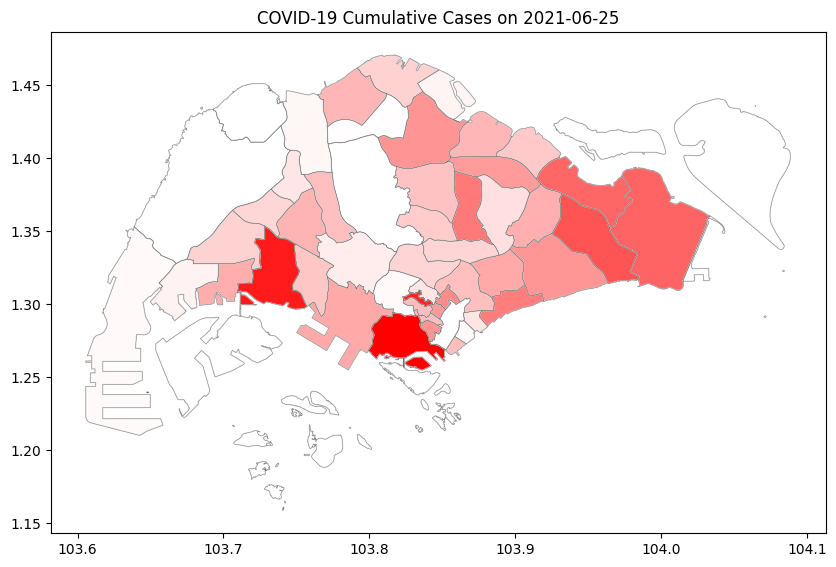

In [15]:
# Animate and save a visualization of cumulative COVID-19 cases on a map, showing updates for each date.
# (Set run_cell to True and rerun the code)
run_cell = True

if run_cell:
    # Define the custom color map
    colors = ['white', 'red']
    cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

    # Define normalization
    norm = Normalize(vmin=cumulative_cases['Cumulative'].min(), vmax=cumulative_cases['Cumulative'].max())

    # Extract unique dates
    unique_dates = sorted(cumulative_cases['Date'].unique())

    # Create a figure and axis
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    # Define the update function for FuncAnimation
    def update(frame):
        ax.clear()

        # Get the current date
        date = unique_dates[frame]

        # Filter data for the current date
        data_for_date = cumulative_cases[cumulative_cases['Date'] == date]

        # Merge with GeoDataFrame
        updated_merged = pd.merge(gdf, data_for_date, left_on='Name', right_on='Name', how='left')

        # Fill NaN values in 'Cumulative' with 0
        updated_merged['Cumulative'] = updated_merged['Cumulative'].fillna(0)

        # Plot boundaries
        gdf.boundary.plot(ax=ax, linewidth=0.1, color='k')

        # Plot the updated data
        updated_merged.plot(column='Cumulative', ax=ax, cmap=cmap, linewidth=0.8, edgecolor='0.8', norm=norm, legend=False)

        # Set the title with total cases
        ax.set_title(f'COVID-19 Cumulative Cases on {date}')

    # Create the animation
    ani = FuncAnimation(fig, update, frames=len(unique_dates), repeat=False)

    # Save the animation as a GIF (optional)
    ani.save('covid_cases_animation.gif', writer=PillowWriter(fps=15))

    # Display the animation
    plt.show()

# Final Visualisation 
Combination of both visualisation technique

### Experimentation

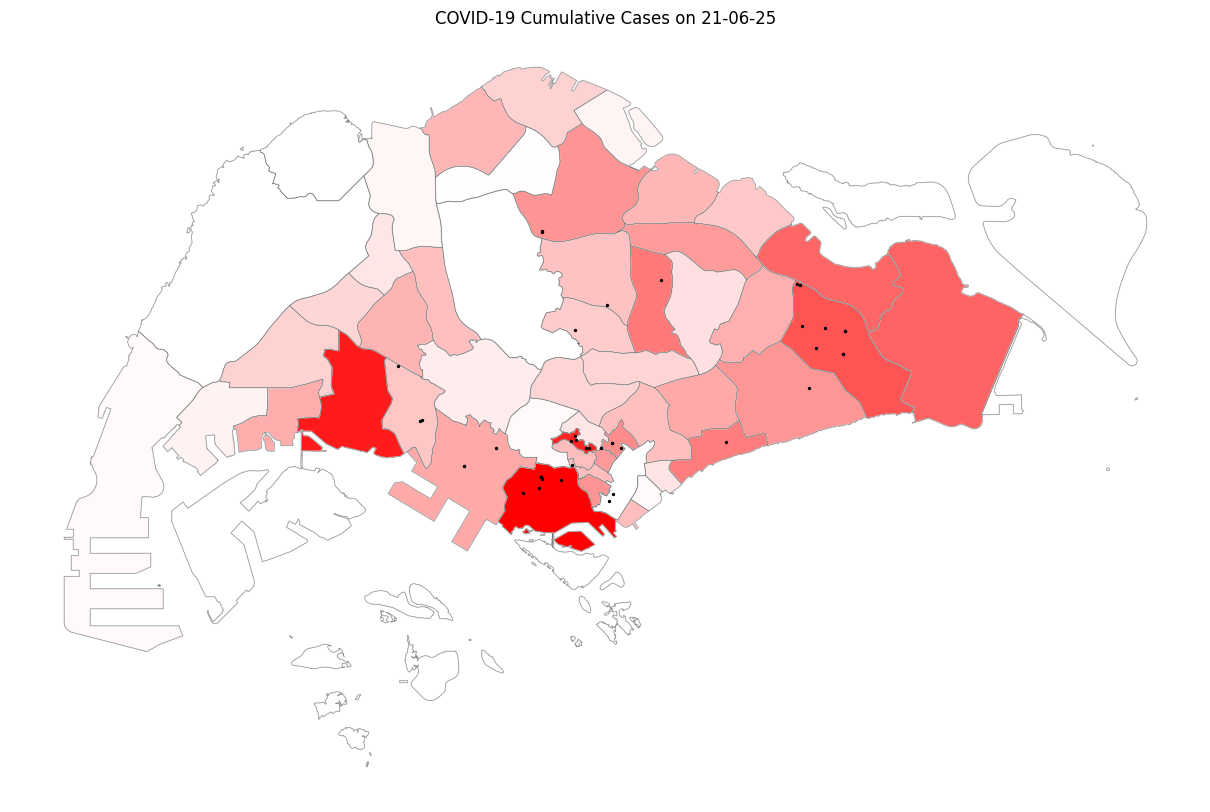

In [21]:
# Create and display choropleth maps with cumulative COVID-19 cases and scatter plots of case locations for each date, 
# showing data from the last 5 days.

# Convert 'Date' in cumulative_cases and covid_clean to datetime
cumulative_cases['Date'] = pd.to_datetime(cumulative_cases['Date'])
covid_clean['Date'] = pd.to_datetime(covid_clean['Date'])

# Assuming cumulative_cases and gdf are defined
unique_dates = sorted(cumulative_cases['Date'].unique())

# Define a custom color map where 0 is white
colors = ['white', 'red']  # Adjust the colors as needed
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

# Define the normalization based on the entire dataset
norm = Normalize(vmin=cumulative_cases['Cumulative'].min(), vmax=cumulative_cases['Cumulative'].max())

# Create a plot

# Loop over each unique date
for i, date in enumerate(unique_dates):
    clear_output(wait=True)
    
    ####### Data Preparation for each frame #######

    # Filter data for the current date
    data_for_date = cumulative_cases[cumulative_cases['Date'] == date]

    # Merge to update GeoDataFrame with current date's data
    updated_merged = pd.merge(gdf, data_for_date, left_on='Name', right_on='Name', how='left')

    # Fill NaN values in 'Cumulative' with 0
    updated_merged['Cumulative'] = updated_merged['Cumulative'].fillna(0)

    # Calculate total cumulative cases for the current date
    total_cases = updated_merged['Cumulative'].sum()
    
    ####### Initialise plot #######
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 10))

    # Clear and redraw the plot
    ax.clear()
    
    ####### Choropleth Map #######
    
    # Plot boundaries
    gdf.boundary.plot(ax=ax, linewidth=0.1, color='k')
    
    # Plot the updated data
    updated_merged.plot(column='Cumulative', ax=ax, cmap=cmap, linewidth=0.8, edgecolor='0.8', norm=norm, legend=False)
    
    ####### Scatter Plot #######
    
    # Filter cases within the last 5 days
    start_date = date - pd.Timedelta(days=5)
    
    cases = covid_clean[(covid_clean['Date'] >= start_date) & (covid_clean['Date'] <= date)]
    
    ax.scatter(cases['Longitude'], cases['Latitude'], color='black', s=2)
    
    ####### Axes Settings #######
    
    # Remove axes
    ax.set_axis_off() 
    
    # Format the date as 'yy-mm-dd'
    formatted_date = pd.Timestamp(date).strftime('%y-%m-%d')

    # Set the title with total cases
    ax.set_title(f'COVID-19 Cumulative Cases on {formatted_date}')
    
    # Save the last frame as a PNG
    if i == len(unique_dates) - 1:
        plt.savefig('SG_Covid_Sitrep.png', bbox_inches='tight', pad_inches=0.1)

    # Display the plot
    plt.show()

    # Close the figure to avoid memory issues
    plt.close(fig)
    

### Animation

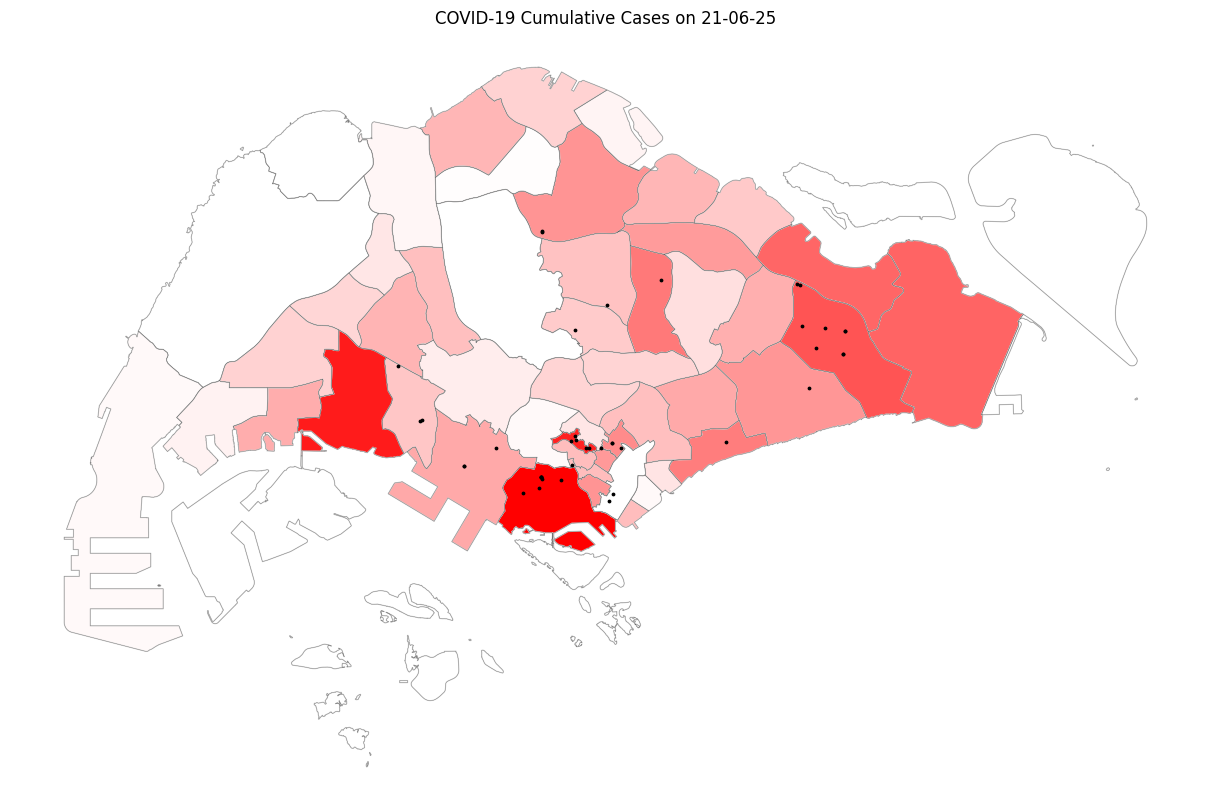

In [18]:
# Create and display an animated visualization of cumulative COVID-19 cases and scatter plots of case locations for each date, 
# incorporating data from the last 5 days.
# (Set run_cell to True and rerun the code)
run_cell = True

if run_cell:
    # Define the custom color map
    colors = ['white', 'red']
    cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

    # Define normalization
    norm = Normalize(vmin=cumulative_cases['Cumulative'].min(), vmax=cumulative_cases['Cumulative'].max())

    # Convert 'Date' in cumulative_cases and covid_clean to datetime
    cumulative_cases['Date'] = pd.to_datetime(cumulative_cases['Date'])
    covid_clean['Date'] = pd.to_datetime(covid_clean['Date'])

    # Extract unique dates
    unique_dates = sorted(cumulative_cases['Date'].unique())

    # Create a figure and axis
    fig, ax = plt.subplots(1, 1, figsize=(20, 10))

    # Define the update function for FuncAnimation
    def update(frame):
        ax.clear()

        ####### Data Preparation for each frame #######

        # Get the current date
        date = unique_dates[frame]

        # Filter data for the current date
        data_for_date = cumulative_cases[cumulative_cases['Date'] == date]

        # Merge with GeoDataFrame
        updated_merged = pd.merge(gdf, data_for_date, left_on='Name', right_on='Name', how='left')

        # Fill NaN values in 'Cumulative' with 0
        updated_merged['Cumulative'] = updated_merged['Cumulative'].fillna(0)

        ####### Choropleth Map #######

        # Plot boundaries
        gdf.boundary.plot(ax=ax, linewidth=0.1, color='k')

        # Plot the updated data
        updated_merged.plot(column='Cumulative', ax=ax, cmap=cmap, linewidth=0.8, edgecolor='0.8', norm=norm, legend=False)

        ####### Scatter Plot #######

        # Filter cases within the last 5 days
        start_date = date - pd.Timedelta(days=5)

        cases = covid_clean[(covid_clean['Date'] >= start_date) & (covid_clean['Date'] <= date)]

        ax.scatter(cases['Longitude'], cases['Latitude'], color='black', s=3)

        ####### Axes Settings #######

        # Remove axes
        ax.set_axis_off() 

        # Format the date as 'yy-mm-dd'
        formatted_date = pd.Timestamp(date).strftime('%y-%m-%d')

        # Set the title with total cases
        ax.set_title(f'COVID-19 Cumulative Cases on {formatted_date}')

    # Create the animation
    ani = FuncAnimation(fig, update, frames=len(unique_dates), repeat=False)

    # Save the animation as a GIF (optional)
    ani.save('finaL_visualisation.gif', writer=PillowWriter(fps=15))

    # Display the animation
    plt.show()

In [19]:
# Display GIF inline in Jupyter Notebook (Uncomment the code and rerun the cell to display the animation)
# gif_path = 'finaL_visualisation.gif'
# display(Image(gif_path))

# Legend Generation

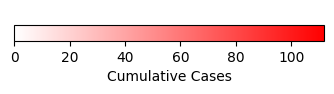

In [20]:
# Generated and saved a horizontal color legend for cumulative COVID-19 cases using a custom red-to-white colormap.

# Define the custom color map
colors = ['white', 'red']
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

# Define normalization
norm = Normalize(vmin=cumulative_cases['Cumulative'].min(), vmax=cumulative_cases['Cumulative'].max())

# Create a new figure for the legend
fig_legend, ax_legend = plt.subplots(figsize=(4, 1))

# Create a colorbar for the legend
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Only needed for colorbar

# Create colorbar with ticks
cbar = plt.colorbar(sm, ax=ax_legend, orientation='horizontal', fraction=0.8, pad=0.1)
cbar.set_label('Cumulative Cases')

# Remove the axis for the legend
ax_legend.set_axis_off()

# Save the legend as an image file
fig_legend.savefig('legend.png', bbox_inches='tight', pad_inches=0.1)

# Display the legend
plt.show()